In [2]:
import math
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader,Dataset
from torch.hub import load_state_dict_from_url
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn.metrics import confusion_matrix, roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Class for loading datasets
class CustomImageDataset(torch.utils.data.Dataset):
    
    # Initialize the dataset with image directory and transform
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.class_names)}
        self.images = []
        self.labels = []
        for class_name in self.class_names:
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith('.JPEG'):
                    self.images.append(os.path.join(class_dir, filename))
                    self.labels.append(self.class_to_idx[class_name])

    # This function returns the number of samples in the dataset.   
    def __len__(self):
        return len(self.images)
    
    # This function returns the image and the label index.
    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels[index]
        image = torchvision.datasets.folder.default_loader(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [4]:
def dataloading(transform):
    # Load the dataset of images and apply the transformation
    dataset = CustomImageDataset(root_dir=r'/kaggle/input/image-classes-dataset/train_set/train_set/train_set')
    
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Set the random seed for reproducibility
    torch.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    
    # Splitting the dataset for validation and training in an 80:20 ratio     
    training_size = int(0.8 * len(dataset))
    validation_size = len(dataset) - training_size
    training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [training_size, validation_size])
    
    training_dataset.dataset.transform = transform
    validation_dataset.dataset.transform = valid_transform

    # Create a DataLoader for the training set and validation set
    training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=16, num_workers=2, shuffle=True, generator=torch.Generator().manual_seed(0))
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=16, num_workers=2, shuffle=False)

    # Get the class names (labels) corresponding to the subfolders in the dataset
    class_names = dataset.class_names
    
    # Return the datasets and dataloaders for training and validation, along with the class names
    return training_dataset, validation_dataset, training_dataloader, validation_dataloader, class_names

In [5]:
# Define the image preprocessing steps
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the training and validation datasets, and create dataloaders for them
training_dataset, validation_dataset, training_dataloader, validation_dataloader, class_names = dataloading(train_transform)

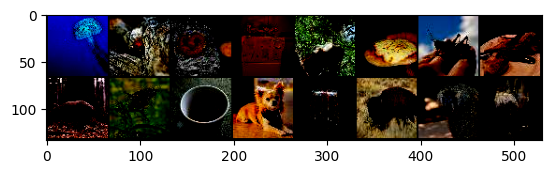

labels ['jellyfish', 'ladybug', 'pretzel', 'refrigerator', 'redpanda', 'pizza', 'grasshopper', 'pretzel', 'pig', 'butterfly', 'espresso', 'chihuahua', 'jellyfish', 'bison', 'baboon', 'pig']


In [6]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
     
data_iter = iter(training_dataloader)
images, labels = next(data_iter)

# show images and labels
timshow(torchvision.utils.make_grid(images))
print(f"labels {[class_names[labels[i]] for i in range(16)]}")

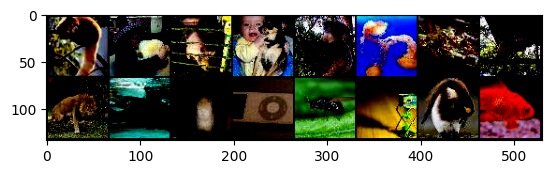

labels ['redpanda', 'sombrero', 'pig', 'chihuahua', 'koala', 'jellyfish', 'pizza', 'koala', 'lion', 'penguin', 'penguin', 'ipod', 'fly', 'hourglass', 'penguin', 'goldfish']


In [7]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
     
data_iter = iter(validation_dataloader)
images, labels = next(data_iter)

# show images and labels
timshow(torchvision.utils.make_grid(images))
print(f"labels {[class_names[labels[i]] for i in range(16)]}")

In [8]:
class MLP(nn.Module):
    
    # Constructor to initialize the MLP layers
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLP, self).__init__()
        
        # Defining three fully connected layers with given input, output sizes
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
        # Adding ReLU activation function
        self.relu = nn.ReLU()  
    
    # Defining the forward pass of the model
    def forward(self, x):
        out = x.reshape(x.shape[0],-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
    
    # This function returns the optimizer function for the model
    def optimizer_function(self, learning_rate):
        return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum = 0.9)
    
    # This function returns the loss function for the model
    def loss_function(self):
        return nn.CrossEntropyLoss() 

In [9]:
# prints an instance of the MLP class 
model = MLP(64 * 64 * 3, 1024, 512, 30)
print(model)

# prints number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

MLP(
  (fc1): Linear(in_features=12288, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=30, bias=True)
  (relu): ReLU()
)
Total parameters: 13124126
